In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cftime
import cmocean as cm
from netCDF4 import Dataset
import os.path
import matplotlib.colors as colors

from matplotlib import gridspec

In [2]:
## folder where the isomip-plus github repo is located
baserepo = '/g/data/x77/cy8964/isomip-plus/'
## folder where you downloaded the zipped Google Drive data
basedrive = '/g/data/x77/cy8964/ISOMIP+Data-new/'

# load the data from the text files, which point to the right location of the file in the drive structure
Ocean0_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean0_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
def get_labels(expt):
    '''
    Get labels of experiments
    Make some modifications to names
    '''
    labels = []
    for fileIndex in range(len(expt)):
        fileName = expt[fileIndex]
        baseName = os.path.basename(basedrive +fileName)
        modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
        if "COM" in fileName:
            #make edits to COM names
            if "MOM6" in fileName:
                if "SIGMA_ZSTAR" not in fileName:
                    modelName = modelName + '-LAYER'
            elif "ROMS" in fileName:
                modelName = "ROMS"
        elif "TYP" in fileName:
            # make edits to COM names
            if "MOM6" in fileName:
                modelName = modelName + '-LAYER'
            elif "CNRS" in fileName:
                if "TYPa" in fileName:
                    modelName = modelName + '-TYPa'
                elif "TYPb" in fileName:
                    modelName = modelName + '-TYPb'
            elif "tides" in fileName:
                modelName = "ROMS-tides"
            elif "ROMS" in fileName:
                modelName = "ROMS"
        labels.append(modelName.strip('V3').replace(" ", "-"))
    return labels


In [3]:
#12 model colours for 12 models, generated using https://colorbrewer2.org/#type=qualitative&scheme=Paired&n=12
modelcolours=['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']


In [4]:
sPerYr = 3600*24*365

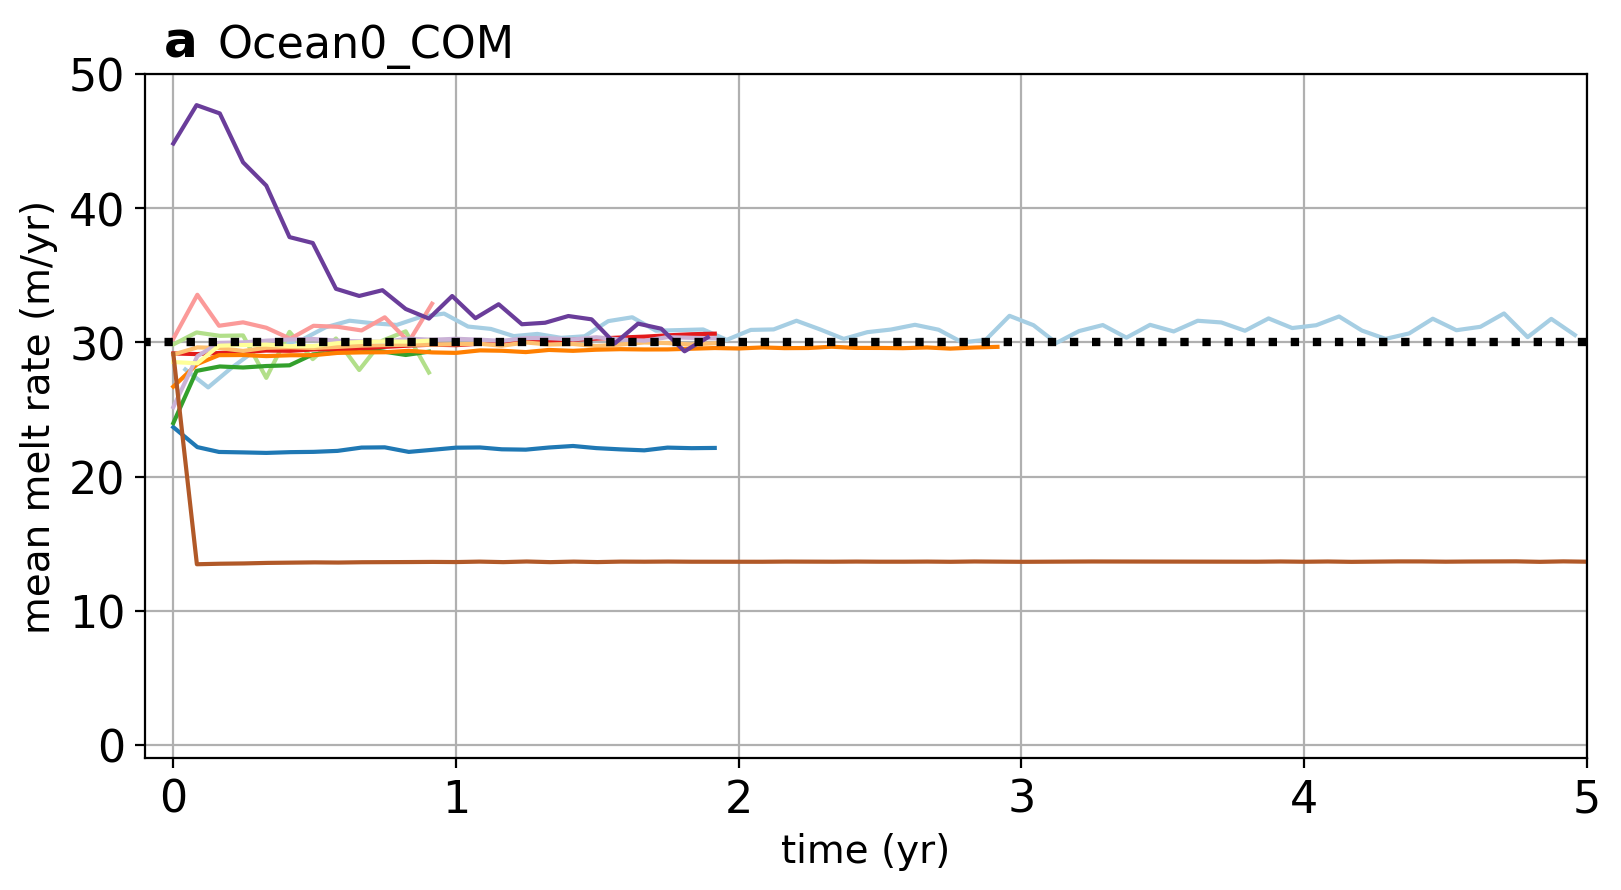

In [9]:
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m']
fig = plt.figure(figsize = (20,10),facecolor='w',dpi = 200)


for k in np.arange(1):
    expt = [Ocean0_COM][k]
    ax = plt.subplot(2,2,k+1)
    title = ['Ocean0_COM'][k]
    labels = get_labels(expt)
    length = len(expt)
        
    for i in np.arange(length):
        ds = xr.open_dataset(basedrive+expt[i], decode_times=False)
        # make x and y coordinates
        ds = ds.set_coords(['x', 'y', 'time'])
        nTime = ds.sizes['nTime']
        mr = ds.meltRate
        
        try:
            draft = ds.iceDraft.isel(nTime = 0)
        except ValueError:
            draft = ds.iceDraft
        # mr < 1e36 is to get rid of fill values.
        mr = sPerYr * mr.where(mr < 1e36).where(mr !=0).where(np.abs(draft) > 300)
        time = ds.time
        if (k==0 or k==2):
            plt.plot(time.values/sPerYr,mr.mean(['nx','ny']).values,
                     color = modelcolours[i], label = labels[i])
        else: # plot TYP colours
            plt.plot(time.values/sPerYr,mr.mean(['nx','ny']).values,
                     color = modelcoloursTYP[i], label = labels[i], linestyle = modelstylesTYP[i])
    
    
    plt.ylabel('mean melt rate (m/yr)', fontsize = 14)
    plt.xlabel('time (yr)', fontsize = 14)
    plt.xlim(-0.5,20)
    plt.text(0.025,1.045,['a','b','c','d'][k],horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=ax.transAxes, fontsize = 18)
    plt.tick_params(labelsize=16)

    # add 30m line for Ocean1
    if k==0:
        plt.hlines([30],-0.5,5,color ='k', linestyle = 'dotted',linewidth = 3,label = '30m/yr')

    if (k==0 or k==1):
        plt.ylim(-1,50)
        plt.xlim(-0.1,5)
    else:
        plt.ylim(0.3,400)
        plt.yscale('log')
        plt.legend(ncols = 2, fontsize = 13)


    plt.grid()
    plt.title(title, fontsize=16,ha='left', x=0.05);

fig.subplots_adjust(hspace = 0.25, wspace = 0.15)

